In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

import tensorflow as tf



from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss
from keras import backend as K
K.set_image_dim_ordering('th') # theano style image dimension ordering (channel,height,width)

In [3]:
import h5py
f = h5py.File("dataset.h5")
x = f['x'].value
y = f['y'].value
f.close()

# splitting data into training and testing with testing size 20%
x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)

In [4]:
# training data
x_train = x_train.astype('float32')
x_train /= 255
# testing data
x_test  = x_test.astype('float32')
x_test /= 255

In [5]:
model = Sequential()
# First layer with 32 filters
# Same padding used for same size output as input
# Rectified linear unit is used as activation function
# Theano style input is used, (channel, input length, input width)
model.add(Convolution2D(32, kernel_size=(3, 3),padding='same',input_shape=(3 , 100, 100)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # For regularization

# Second layer with 64 filters
# Same padding, relu as activation
model.add(Convolution2D(64,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # For regularizarion

# Final Classification Layer
# Densely connected layer for image classification
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('sigmoid')) # Sigmoid activation for final class probabilities


In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1600, 3, 100, 100)
(400, 3, 100, 100)
(1600, 5)
(400, 5)


In [7]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Loading weightd from trained model
model.load_weights("weights.hdf5")

# training model and saving weights in hdf5 format, will use later
# check = ModelCheckpoint("weights.{epoch:02d}-{val_acc:.5f}.hdf5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
# model.fit(x_train, y_train, batch_size=32, epochs=20,callbacks=[check],validation_data=(x_test,y_test))

In [8]:
out = model.predict_proba(x_test)
out = np.array(out)

400/400 [==============================] - 38s    


In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 100, 100)      896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 100, 100)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 98, 98)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 32, 98, 98)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 49, 49)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 49, 49)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 49, 49)        18496     
__________

In [9]:
print(out)
print(out.shape)
print(out.shape[1]) # Number of classes

[[  5.25076203e-02   3.81865650e-01   7.11545348e-01   3.03906891e-02
    2.52192736e-01]
 [  5.26889190e-02   9.62114485e-04   2.93579310e-01   9.72158492e-01
    5.14680594e-02]
 [  3.49882767e-02   3.71032394e-03   5.97689509e-01   9.70311403e-01
    2.65014009e-03]
 ..., 
 [  1.75322279e-01   4.29682294e-03   3.18148553e-01   9.09448683e-01
    3.30147445e-02]
 [  4.86279791e-03   5.00628464e-02   5.54790735e-01   3.92153254e-03
    4.14285213e-01]
 [  3.66324298e-02   5.57558119e-01   4.78138864e-01   7.09356973e-03
    2.37569913e-01]]
(400, 5)
5


In [33]:
threshold = np.arange(0.1,0.9,0.1)

# Taking threshold valued for different classes
# taking threshold to be the value in range(0.1 - 0.9) at which
# matthews correlation coefficient is maximum
classes=out.shape[1]
# print(classes)
best_threshold = np.zeros(out.shape[1])
for i in range(classes):
    accuracy = []
    y_prob = np.array(out[:,i])
    for j in threshold:
        y_pred = [1 if prob>=j else 0 for prob in y_prob]
        accuracy.append( matthews_corrcoef(y_test[:,i],y_pred))
        # accuracy.append( confusion_matrix(y_test[:,i],y_pred)[0][0])
        # accuracy.append( classification_report(y_test[:,i],y_pred))
        
    accuracy = np.array(accuracy)
    index = np.where(accuracy==accuracy.max()) 
#     print(len(index))
    best_threshold[i] = threshold[index[0][0]]
# print(index)

In [46]:
print(best_threshold)
y_pred = np.array([[1 if out[i,j]>=best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])
print(y_pred[0])

[ 0.6  0.3  0.5  0.3  0.7]
[0 1 1 0 0]


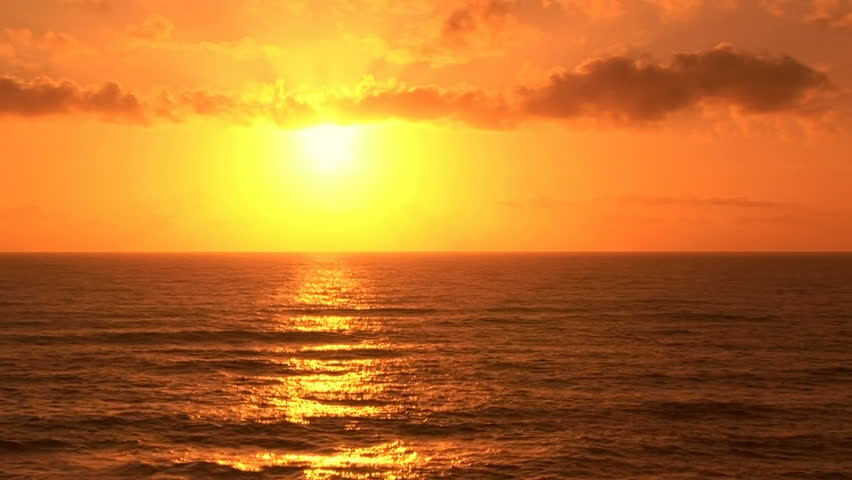

In [39]:
from IPython.display import Image
Image(filename='test_image.jpg')

In [30]:
import cv2
import os
image_name="test_image.jpg"
image_path=os.path.join(os.getcwd(),image_name)
print(image_path)
img=cv2.imread(image_path)
# img.shape
img=cv2.resize(img,(100,100))
img = img.transpose((2,0,1))
# img.shape   
img = img.astype('float32')
img = img/255
img = np.expand_dims(img,axis=0)

/Users/ashu/Desktop/mlai/hash_tag/test_image.jpg


In [44]:
pred = model.predict(img) # test model prediction
# print(pred)
y_pred = [1 if pred[0,i]>=best_threshold[i] else 0 for i in range(pred.shape[1])]
y_pred = np.array(y_pred)
# print(y_pred)
classes = ['desert','mountains','sea','sunset','trees']
print("The Image contains : " + str([classes[i] for i in range(len(classes)) if y_pred[i]==1 ]))

The Image contains : ['sea', 'sunset']
